# explore the BOKU NDVI data -> VCI3M

In [288]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/tommylees/github/ml_drought


In [300]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

data_dir = Path('data/')
# data_dir = Path('/Volumes/Lees_Extend/data/zip_data')
data_dir = Path('/Volumes/Lees_Extend/data/ecmwf_sowc/data/')
plot_dir = Path('/Users/tommylees/Downloads')

assert data_dir.exists()

In [330]:
import seaborn as sns
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data

In [389]:
EXPERIMENT = 'one_month_forecast_BOKU_VCI3M_our_vars_ALL'
TRUE_EXPERIMENT = 'one_month_forecast_BOKU_VCI3M_our_vars'
TARGET_VAR = 'VCI3M'

# Read in the data

In [378]:
X_train, y_train = read_train_data(data_dir, experiment=TRUE_EXPERIMENT)
X_test, y_test = read_test_data(data_dir, experiment=TRUE_EXPERIMENT)
static_ds = xr.open_dataset(data_dir / "features/static/data.nc")

ds = xr.merge([y_train, y_test]).sortby('time').sortby('lat')
d_ = xr.merge([X_train, X_test]).sortby('time').sortby('lat')
ds = xr.merge([ds, d_])

In [394]:
print("ALL DATA:")
display(ds)
print('\n\n')
print("TARGET VARIABLE:")
display(y_test)

assert TARGET_VAR == [v for v in y_test.data_vars][0]

ALL DATA:


<xarray.Dataset>
Dimensions:     (lat: 45, lon: 35, time: 205)
Coordinates:
  * time        (time) datetime64[ns] 2001-12-31 2002-01-31 ... 2018-12-31
  * lon         (lon) float64 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
  * lat         (lat) float64 -5.0 -4.75 -4.5 -4.25 -4.0 ... 5.25 5.5 5.75 6.0
Data variables:
    VCI3M       (time, lat, lon) float64 nan nan nan nan ... 58.68 73.7 48.96
    p84.162     (time, lat, lon) float64 1.45e-05 -5.456e-05 ... nan nan
    pev         (time, lat, lon) float64 -0.005993 -0.006077 ... nan nan
    sp          (time, lat, lon) float64 8.862e+04 8.927e+04 ... nan nan
    t2m         (time, lat, lon) float64 297.5 298.4 297.4 296.2 ... nan nan nan
    tp          (time, lat, lon) float64 0.003657 0.00285 0.004386 ... nan nan
    VCI         (time, lat, lon) float64 57.69 89.55 63.82 45.12 ... nan nan nan
    precip      (time, lat, lon) float64 102.0 107.6 122.3 111.1 ... nan nan nan
    E           (time, lat, lon) float64 85.9 60.61 60.61




TARGET VARIABLE:


<xarray.Dataset>
Dimensions:  (lat: 45, lon: 35, time: 36)
Coordinates:
  * lon      (lon) float64 33.75 34.0 34.25 34.5 34.75 ... 41.5 41.75 42.0 42.25
  * lat      (lat) float64 6.0 5.75 5.5 5.25 5.0 ... -4.0 -4.25 -4.5 -4.75 -5.0
  * time     (time) datetime64[ns] 2016-01-31 2016-02-29 ... 2018-12-31
Data variables:
    VCI3M    (time, lat, lon) float64 55.99 48.25 67.82 63.62 ... nan nan nan

In [386]:
from src.utils import get_ds_mask
mask = get_ds_mask(X_train.VCI)

bline_pred = read_pred_data('previous_month', data_dir, experiment=EXPERIMENT)[-1].where(~mask)
lstm_pred = read_pred_data('rnn', data_dir, experiment=EXPERIMENT)[-1].where(~mask)
ealstm_pred = read_pred_data('ealstm', data_dir, experiment=EXPERIMENT)[-1].where(~mask

### Model Performance Data

In [395]:
from src.analysis import spatial_rmse, spatial_r2

# -------- LSTM
lstm_rmse = spatial_rmse(
    y_test[TARGET_VAR].transpose("time", "lat", "lon"), 
    lstm_pred.transpose("time", "lat", "lon")
)

# -------- EALSTM
ealstm_rmse = spatial_rmse(
    y_test[TARGET_VAR].transpose("time", "lat", "lon"), 
    ealstm_pred.transpose("time", "lat", "lon")
)

# -------- Baseline
bline_rmse = spatial_rmse(
    y_test[TARGET_VAR].transpose("time", "lat", "lon"), 
    bline_pred.transpose("time", "lat", "lon")
)


# calculate mean performance scores
lstm_mean = lstm_rmse.mean().values
ealstm_mean = ealstm_rmse.mean().values
bline_mean = bline_rmse.mean().values

print("lstm_mean RMSE: ".ljust(20), f"{lstm_mean:.2f}")
print("ealstm_mean RMSE: ".ljust(20), f"{ealstm_mean:.2f}")
print("bline_mean RMSE: ".ljust(20), f"{bline_mean:.2f}")

lstm_mean RMSE:      22.21
ealstm_mean RMSE:    18.57
bline_mean RMSE:     22.85


# Model Performance

In [398]:
print("lstm_mean RMSE: ".ljust(20), f"{lstm_mean:.2f}")
print("ealstm_mean RMSE: ".ljust(20), f"{ealstm_mean:.2f}")
print("bline_mean RMSE: ".ljust(20), f"{bline_mean:.2f}")

lstm_mean RMSE:      22.21
ealstm_mean RMSE:    18.57
bline_mean RMSE:     22.85


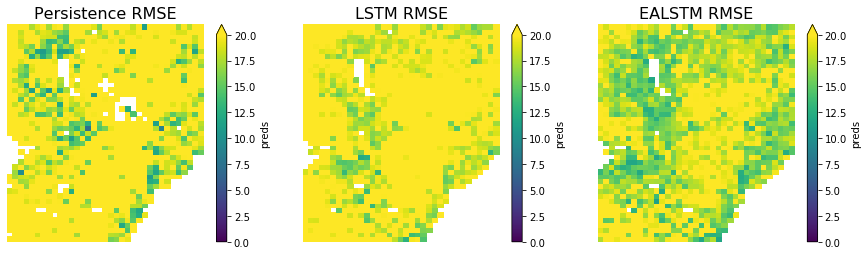

In [400]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
kwargs = {'vmin': 0, 'vmax': 20}

bline_rmse.plot(ax=axs[0], **kwargs)
axs[0].set_title('Persistence RMSE', size=16);

lstm_rmse.plot(ax=axs[1], **kwargs)
axs[1].set_title('LSTM RMSE', size=16);

ealstm_rmse.plot(ax=axs[2], **kwargs)
axs[2].set_title('EALSTM RMSE', size=16);

for ax in axs:
    ax.set_axis_off()

### Error over time

In [403]:
def calculate_error(true_da, pred_da, method=None):
    if method == 'squared':
        vals = (true_da.values - pred_da.values) ** 2
    elif method == 'absolute':
        vals = abs((true_da.values - pred_da.values))
    else:
        vals = (true_da.values - pred_da.values)
    da = xr.ones_like(true_da) * vals
    return da.rename(f'{method + "_" if method is not None else ""}error')


ealstm_error = calculate_error(
    pred_da=ealstm_pred.transpose("time", "lat", "lon"),
    true_da=y_test[TARGET_VAR].transpose("time", "lat", "lon"),
    method='squared'
)
lstm_error = calculate_error(
    pred_da=lstm_pred.transpose("time", "lat", "lon"),
    true_da=y_test[TARGET_VAR].transpose("time", "lat", "lon"),
    method='squared'
)
bline_error = calculate_error(
    pred_da=bline_pred.transpose("time", "lat", "lon"),
    true_da=y_test[TARGET_VAR].transpose("time", "lat", "lon"),
    method='squared'
)

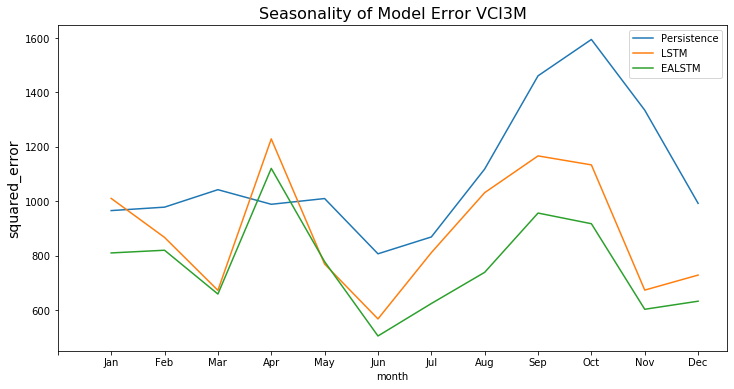

In [405]:
import calendar 
mths = [m for m in calendar.month_abbr]
fig, ax = plt.subplots(figsize=(12, 6))

bline_error.groupby('time.month').mean().plot(ax=ax, label='Persistence')
lstm_error.groupby('time.month').mean().plot(ax=ax, label='LSTM')
ealstm_error.groupby('time.month').mean().plot(ax=ax, label='EALSTM')
plt.legend()

ax.set_title(f'Seasonality of Model Error {TARGET_VAR}', size=16);
ax.set_xticks([i for i in range(0, 13)])
ax.set_xticklabels(mths)
ax.set_ylabel(bline_error.name, size=14)
fig.savefig(f'/Users/tommylees/Downloads/model_error_seasonality_{TARGET_VAR}.png');

#### How does persistence error vary and how does that correspond with the raw NDVI values?

Note: the interpretation of this error is always slightly difficult because the VCI is de-seasonalised and so we do not expect to find any seasonal pattern in the VCI (nor necessarily our results)...

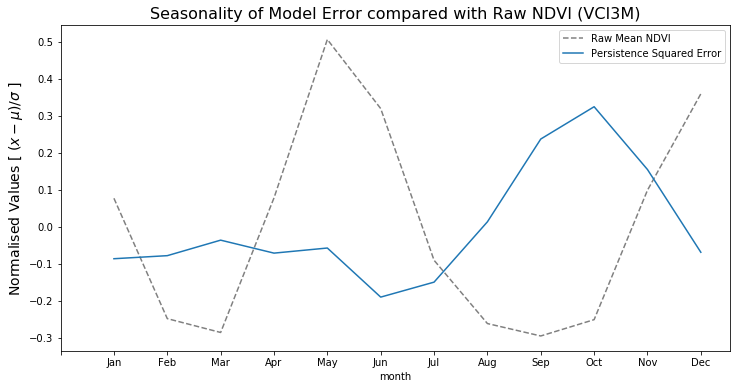

In [407]:
fig, ax = plt.subplots(figsize=(12, 6))
mths = [m for m in calendar.month_abbr]

# normalise the NDVI seasonality
(
    (ds.modis_ndvi.groupby('time.month').mean() - ds.modis_ndvi.mean()) / ds.modis_ndvi.std()
).plot(ax=ax, label='Raw Mean NDVI', color='grey', ls='--')


# normalise the persistence model error seasonality (Error)
(
    (bline_error.groupby('time.month').mean() - bline_error.mean()) / bline_error.std()
).plot(ax=ax, label='Persistence Squared Error')

ax.set_title(f'Seasonality of Model Error compared with Raw NDVI ({TARGET_VAR})', size=16);
ax.set_ylabel('Normalised Values [ $(x - \mu) / \sigma$ ]', size=14)
ax.set_xticks([i for i in range(0, 13)])
ax.set_xticklabels(mths)
plt.legend();
fig.savefig(f'/Users/tommylees/Downloads/model_error_seasonality_{TARGET_VAR}.png')

### What if we compare our VCI products? 
It looks pretty fucked truth be told. It looks like the BOKU VCI must have an error in the calculation

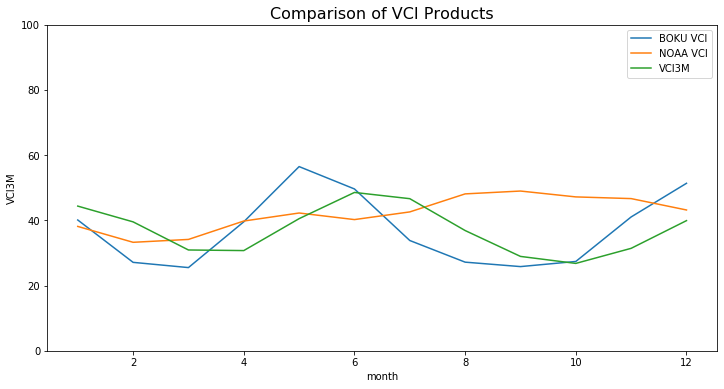

In [411]:
fig, ax = plt.subplots(figsize=(12, 6))
ds.boku_VCI.groupby('time.month').mean().plot(ax=ax, label='BOKU VCI')
ds.VCI.groupby('time.month').mean().plot(ax=ax, label='NOAA VCI')
ds.VCI3M.groupby('time.month').mean().plot(ax=ax, label='VCI3M')
ax.set_title(f'Comparison of VCI Products', size=16);
ax.set_ylim([0, 100])
plt.legend();

fig.savefig(plot_dir / f'VCI_product_seasonality.png')

### Have we normalised the seasonality?

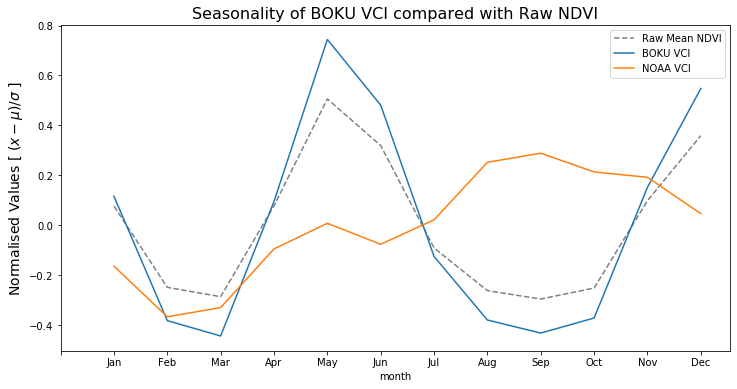

In [412]:
fig, ax = plt.subplots(figsize=(12, 6))
mths = [m for m in calendar.month_abbr]

# normalise the NDVI seasonality
(
    (ds.modis_ndvi.groupby('time.month').mean() - ds.modis_ndvi.mean()) / ds.modis_ndvi.std()
).plot(ax=ax, label='Raw Mean NDVI', color='grey', ls='--')


# normalise the BOKU VCI
(
    (ds.boku_VCI.groupby('time.month').mean() - ds.boku_VCI.mean()) / ds.boku_VCI.std()   
).plot(ax=ax, label='BOKU VCI')

# normalise the NOAA VCI seasonality (Error)
(
    (ds.VCI.groupby('time.month').mean() - ds.VCI.mean()) / ds.VCI.std()   
).plot(ax=ax, label='NOAA VCI')


ax.set_title('Seasonality of BOKU VCI compared with Raw NDVI', size=16);
ax.set_ylabel('Normalised Values [ $(x - \mu) / \sigma$ ]', size=14)
ax.set_xticks([i for i in range(0, 13)])
ax.set_xticklabels(mths)
plt.legend();
fig.savefig('/Users/tommylees/Downloads/model_VCI_NDVI_seasonality.png')

# Region Analysis

In [414]:
from src.analysis.region_analysis import RegionGeoPlotter, AdministrativeRegionAnalysis
warnings.filterwarnings('ignore')

analyzer = AdministrativeRegionAnalysis(
    data_dir=data_dir,
    experiment=EXPERIMENT,
    true_data_experiment=TRUE_EXPERIMENT
)
r = RegionGeoPlotter(data_dir)

Initialised the Region Analysis for experiment: one_month_forecast_BOKU_VCI3M_our_vars_ALL
Models: ['ealstm', 'previous_month', 'rnn']
Regions: ['district_l2_kenya.nc']
Region Type: administrative_boundaries
GroupbyRegion requires geopandas to be installed


In [415]:
region_path = analyzer.region_data_paths[0]
admin_level_name = region_path.name.replace('.nc', '')
region_da, region_lookup, region_group_name = analyzer.load_region_data(region_path)
valid_region_ids = [k for k in region_lookup.keys()]

In [416]:
def get_region_mask(region: str):
    lookup = dict(zip(region_lookup.values(), region_lookup.keys()))
    region_id = lookup[region]
    
    return ~region_da.where(region_da == region_id).isnull()

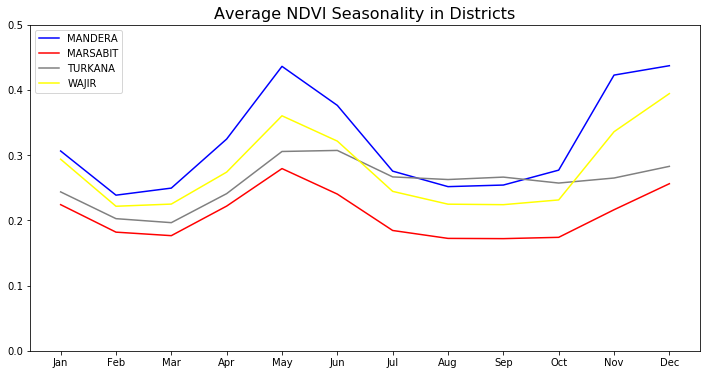

In [417]:
import calendar
mths = [m for m in calendar.month_abbr if m != ""]

colors = ['blue', 'red', 'grey', 'yellow']
regions = ["MANDERA", "MARSABIT", "TURKANA", "WAJIR"]
fig, ax = plt.subplots(figsize=(12, 6))
for ix, region in enumerate(regions):
    msk = get_region_mask(region)
    df = ds.modis_ndvi.where(msk).groupby('time.month').mean().to_dataframe().set_index(pd.Series(mths)).rename(columns={'modis_ndvi': region})

    df.plot(ax=ax, color=colors[ix])

ax.set_ylim([0, 0.5])
ax.set_xticks([i for i in range(0, 12)])
ax.set_xticklabels(mths)
plt.legend()
ax.set_title('Average NDVI Seasonality in Districts', size=16);


### Make region dataframe

In [418]:
import pickle

analyzer.analyze()

* Analyzing for district_l2_kenya *

** Analyzing for ealstm-district_l2_kenya **
** Written ealstm csv to /Volumes/Lees_Extend/data/ecmwf_sowc/data/analysis/region_analysis/ealstm/ealstm_district_l2_kenya.csv **

** Analyzing for previous_month-district_l2_kenya **
** Written previous_month csv to /Volumes/Lees_Extend/data/ecmwf_sowc/data/analysis/region_analysis/previous_month/previous_month_district_l2_kenya.csv **

** Analyzing for rnn-district_l2_kenya **
** Written rnn csv to /Volumes/Lees_Extend/data/ecmwf_sowc/data/analysis/region_analysis/rnn/rnn_district_l2_kenya.csv **
* Assigned all region dfs to `self.df` *

* Assigned Global Error Metrics to `self.global_mean_metrics` *
* Written csv to data/analysis/region_analysis/global_error_metrics_one_month_forecast_BOKU_VCI3M_our_vars_ALL_admin.csv *

* Assigned Regional Error Metrics to `self.regional_mean_metrics` *
* Written csv to data/analysis/region_analysis/regional_error_metrics_one_month_forecast_BOKU_VCI3M_our_vars_ALL_ad

In [419]:
region_plotter = analyzer.create_model_performance_by_region_geodataframe()
df = analyzer.df
gdf = region_plotter.gdf

GroupbyRegion requires geopandas to be installed
Reading file: KEN_admin2_2002_DEPHA.shp
Reading file: Ken_Districts.shp
Reading file: Ken_Divisions.shp
Reading file: Kenya wards.shp
Reading file: Ken_Locations.shp
Reading file: Ken_Sublocations.shp
* Read shapefiles and stored in `RegionGeoPlotter.region_gdfs` *
* Assigned the complete GeoDataFrame to `RegionGeoPlotter.gdf`


In [420]:
all_gdf = region_plotter.merge_all_model_performances_gdfs(analyzer.df)
all_gdf.head()

* Assigned the complete GeoDataFrame to `RegionGeoPlotter.gdf`


,admin_level_name,model,datetime,region_name,predicted_mean_value,true_mean_value,DISTNAME,geometry
0,district_l2_kenya,ealstm,2016-01-31,NAIROBI,72.922180,78.104575,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...
1,district_l2_kenya,rnn,2016-01-31,NAIROBI,70.721909,78.104575,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...
2,district_l2_kenya,previous_month,2016-01-31,NAIROBI,64.466231,78.104575,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...
3,district_l2_kenya,rnn,2016-02-29,NAIROBI,86.350807,84.477124,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...
4,district_l2_kenya,ealstm,2016-02-29,NAIROBI,82.315056,84.477124,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...


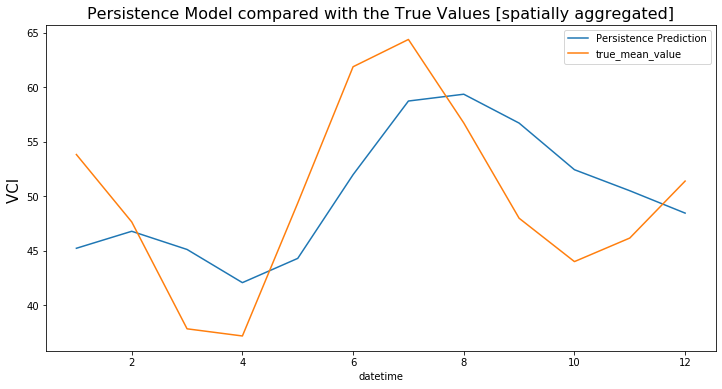

In [421]:
# all_gdf.loc[(all_gdf.model == 'previous_month') & (all_gdf.region_name == 'TURKANA')]
fig, ax = plt.subplots(figsize=(12, 6))
ts = all_gdf.loc[(all_gdf.model == 'previous_month')].groupby('datetime').mean()
ts.groupby(ts.index.month).mean().rename(columns={'predicted_mean_value': 'Persistence Prediction'}).plot(ax=ax)
ax.set_title('Persistence Model compared with the True Values [spatially aggregated]', size=16);
ax.set_ylabel('VCI ', size=15)

fig.savefig('/Users/tommylees/Downloads/persistence_model_seasonality.png')

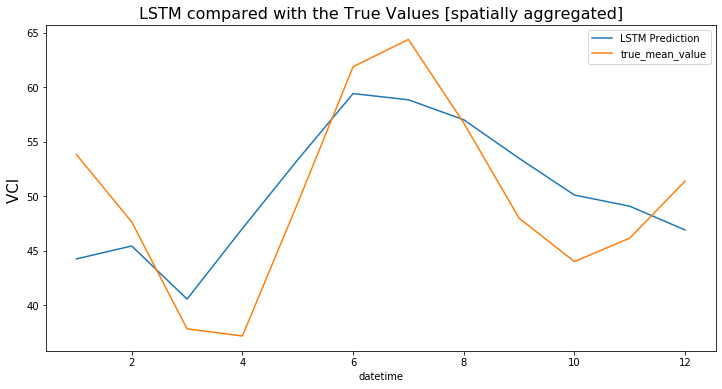

In [422]:
# all_gdf.loc[(all_gdf.model == 'previous_month') & (all_gdf.region_name == 'TURKANA')]
fig, ax = plt.subplots(figsize=(12, 6))
ts = all_gdf.loc[(all_gdf.model == 'rnn')].groupby('datetime').mean()
ts.groupby(ts.index.month).mean().rename(columns={'predicted_mean_value': 'LSTM Prediction'}).plot(ax=ax)
ax.set_title('LSTM compared with the True Values [spatially aggregated]', size=16);
ax.set_ylabel('VCI ', size=15)

fig.savefig('/Users/tommylees/Downloads/lstm_model_seasonality.png')

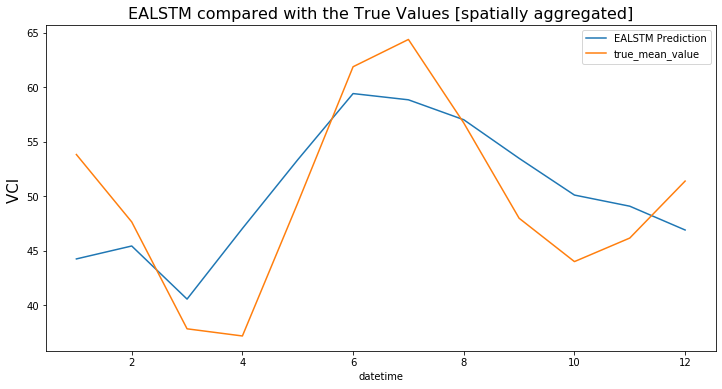

In [423]:
# all_gdf.loc[(all_gdf.model == 'previous_month') & (all_gdf.region_name == 'TURKANA')]
fig, ax = plt.subplots(figsize=(12, 6))
ts = all_gdf.loc[(all_gdf.model == 'rnn')].groupby('datetime').mean()
ts.groupby(ts.index.month).mean().rename(columns={'predicted_mean_value': 'EALSTM Prediction'}).plot(ax=ax)
ax.set_title('EALSTM compared with the True Values [spatially aggregated]', size=16);
ax.set_ylabel('VCI ', size=15)
fig.savefig('/Users/tommylees/Downloads/ealstm_model_seasonality.png')

# Paper Analysis

### Q1: RMSE for each District

In [424]:
from typing import Tuple, List, Dict, Optional

def analyze_region(
        region_name: str, 
        district_map: xr.Dataset, 
        model_experiment: str, 
        true_data_experiment: str,
        model: str,
        target_var: str = 'VCI') -> Tuple[float, float]:

    region_lookup: Dict = dict(
            zip(
                [v.strip() for v in district_map.attrs["values"].split(",")],
                [int(k.strip()) for k in district_map.attrs["keys"].split(",")],
            )
        )
    
    district_int = region_lookup[region_name]
    
    rmse: List[np.ndarray] = []
    
    for file_name in (data_dir / 'features' / true_data_experiment / 'test').glob("*"):
        year, month = file_name.name.split("_")
        
        # read the observed (true) data
        true_file = xr.open_dataset(file_name / "y.nc").where(
            district_map.district_l2 == district_int).rename({target_var: "preds"}
        ).isel(time=0)

        # read predictions
        model_file = xr.open_dataset(
            data_dir / 'models' / model_experiment / model / f"preds_{year}_{month}.nc"
        ).where(district_map.district_l2 == district_int)
        
        model_err = (model_file - true_file).preds.values
        model_err = model_err[~np.isnan(model_err)]
        rmse.append(np.sqrt(model_err ** 2))
    
    return np.concatenate(rmse).mean()


district_map = xr.open_dataset(data_dir / "analysis/boundaries_preprocessed/district_l2_kenya.nc")

results: Dict[str, Dict[str, float]] = {}
for model in ["ealstm", "previous_month", "rnn"]:
    results[model] = {}
    for region in ["TURKANA", "MANDERA", "MARSABIT", "WAJIR"]:
        results[model][region] = analyze_region(
            region, 
            district_map, 
            EXPERIMENT,
            EXPERIMENT,
            model=model,
            target_var='boku_VCI'
        )

ValueError: need at least one array to concatenate

In [ ]:
results

### Q2: R2 for each District

In [ ]:
data = analyzer.compute_regional_error_metrics()

for model in ["previous_month", "rnn", "ealstm"]:
    for region in ["MANDERA", "MARSABIT", "TURKANA", "WAJIR"]:
        row = data[(data.model == model) & (data.region_name == region) & 
                  (data.admin_level_name == "district_l2_kenya")]
        print(f"For {model} in {region}, r2: {row.r2.iloc[0]}, rmse: {row.rmse.iloc[0]}")

### Q4: VCI3M (aggregating the dataframe)

NOTE: this is probably more accurately done using the experiments for actually predicting VCI3M

In [ ]:
from sklearn.metrics import r2_score

def rolling_average(df: pd.DataFrame, years: Optional[List[int]] = None) -> Dict[str, float]:
    assert len(df.model.unique()) == 1, "Pass a single dataframe model to this function" \
        f"Currently: {df.model.unique()}"
    relevant_districts = ['Mandera', 'Marsabit', 'Turkana', 'Wajir']

    if years is None:
        years = [2016, 2017]  # to reflect the Adede paper

    # create columns
    df["month"] = pd.to_datetime(df.datetime).dt.month
    df["year"] = pd.to_datetime(df.datetime).dt.year

    output_dict: Dict[str: float] = {}

    for district in relevant_districts:
        for year in years:
            # the year of interest
            year_df = df[df.year == year]
            # district of interset
            district_df = year_df[year_df.region_name == district.upper()]
            # get the relevant TIME SLICE
            true, predicted = [], []
            for i in range(1, 12 - 1):
                min_month = i
                max_month = i + 3
                submonth = district_df[(district_df.month >= min_month) & (district_df.month < max_month)]
                predicted.append(submonth.predicted_mean_value.mean())
                true.append(submonth.true_mean_value.mean())
        # calculate the r^2 score
        district_score = r2_score(true, predicted)
        print(f'For {district}, r2 score: {district_score}')
        output_dict[district] = district_score
    return output_dict

In [ ]:
for model in ['previous_month', 'rnn', 'ealstm']:
    print(f"** MODEL: {model} **")
    rolling_average(
        df=df.loc[df.model == model]
    )
    print()